# Accretion disc

In this tutorial we set up a protoplanetary disc around a star represented by a sink particle, and we add a planet. This notebook generates a Phantom "temporary" dump file that can be read by Phantom as an initial condition. It also generates a Phantom "in" file. Together, these files can start a Phantom simulation.

## Initialization

First we import the required modules.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import phantomsetup

Here we set some constants for convenience.

In [2]:
igas = phantomsetup.defaults.PARTICLE_TYPE['igas']

## Parameters

Now we set the parameters for the problem.

First is the `prefix` which sets the file name for the dump file and Phantom in file.

In [3]:
prefix = 'disc'

### Resolution

We choose the resolution to be $10^6$ gas particles.

In [4]:
number_of_particles = 1_000_000
particle_type = igas

### Viscosity

The SPH $\alpha$ viscosity parameter is its minimal value of 0.1.

In [5]:
alpha_artificial = 0.1

### Units

We set the length and mass units to be au and solar masses, respectively. We will also set the time unit such that the gravitational constant is unity.

In [6]:
length_unit = phantomsetup.units.unit_string_to_cgs('au')
mass_unit = phantomsetup.units.unit_string_to_cgs('solarm')
gravitational_constant = 1.0

### Star

The star is of solar mass, at the origin, with a 5 au accretion radius.

In [7]:
stellar_mass = 1.0
stellar_accretion_radius = 5.0
stellar_position = (0.0, 0.0, 0.0)
stellar_velocity = (0.0, 0.0, 0.0)

### Disc

The disc has mass 0.01 solar masses, it extends from 10 au to 200 au.

In [8]:
radius_min = 10.0
radius_max = 200.0

In [9]:
disc_mass = 0.01

### Equation of state

The equation of state is locally isothermal. We set the aspect ratio H/R at a reference radius.

In [10]:
ieos = 3
q_index = 0.75
aspect_ratio = 0.05
reference_radius = 10.0

### Planet

We add a planet at 100 au.

In [11]:
planet_mass = 0.001
planet_position = (100.0, 0.0, 0.0)

In [12]:
orbital_radius = np.linalg.norm(planet_position)
planet_velocity = np.sqrt(gravitational_constant * stellar_mass / orbital_radius)

We set the planet accretion radius as a fraction of the Hill sphere radius.

In [13]:
planet_accretion_radius_fraction_hill_radius = 0.25

In [14]:
planet_hill_radius = phantomsetup.orbits.hill_sphere_radius(
    orbital_radius, planet_mass, stellar_mass
)
planet_accretion_radius = (
    planet_accretion_radius_fraction_hill_radius * planet_hill_radius
)

### Surface density distribution

For the surface density distribution we use the Lynden-Bell and Pringle (1974) self-similar solution, i.e. a power law with an exponential taper.

In [15]:
def density_distribution(radius, radius_critical, gamma):
    """Self-similar disc surface density distribution.

    This is the Lyden-Bell and Pringle (1974) solution, i.e. a power law
    with an exponential taper.
    """
    return phantomsetup.disc.self_similar_accretion_disc(radius, radius_critical, gamma)

radius_critical = 100.0
gamma = 1.0

In [16]:
args = (radius_critical, gamma)

## Instantiate the `Setup` object

The following instantiates the `phantomsetup.Setup` object.

In [17]:
setup = phantomsetup.Setup()

## Set attributes and add particles

### Prefix

Set the prefix.

In [18]:
setup.prefix = prefix

### Units

Set units.

In [19]:
setup.set_units(
    length=length_unit, mass=mass_unit, gravitational_constant_is_unity=True
)

PhantomSetup('disc')

### Equation of state

Set the equation of state. We get `polyk` from the aspect ratio parametrization.

In [20]:
polyk = phantomsetup.eos.polyk_for_locally_isothermal_disc(
    q_index, reference_radius, aspect_ratio, stellar_mass, gravitational_constant
)

In [21]:
setup.set_equation_of_state(ieos=ieos, polyk=polyk)

PhantomSetup('disc')

### Viscosity

Set the numerical viscosity to Phantom disc viscosity.

In [22]:
setup.set_dissipation(disc_viscosity=True, alpha=alpha_artificial)

PhantomSetup('disc')

### Star

Add a star at the origin.

In [23]:
setup.add_sink(
    mass=stellar_mass,
    accretion_radius=stellar_accretion_radius,
    position=stellar_position,
    velocity=stellar_velocity,
)

PhantomSetup('disc')

### Disc

Add the disc around the star.

In [24]:
disc = phantomsetup.Disc(
    particle_type=particle_type,
    number_of_particles=number_of_particles,
    disc_mass=disc_mass,
    density_distribution=density_distribution,
    radius_range=(radius_min, radius_max),
    q_index=q_index,
    aspect_ratio=aspect_ratio,
    reference_radius=reference_radius,
    stellar_mass=stellar_mass,
    gravitational_constant=gravitational_constant,
    extra_args=(radius_critical, gamma),
)

setup.add_container(disc)

PhantomSetup('disc')

### Planet

Add a planet in orbit around the star.

In [25]:
setup.add_sink(
    mass=planet_mass,
    accretion_radius=planet_accretion_radius,
    position=planet_position,
    velocity=planet_velocity,
)

PhantomSetup('disc')

## Plot

Now we plot some quantities to see what we have set up.

First is the particles in the xy-plane. The sink particles are marked in red.

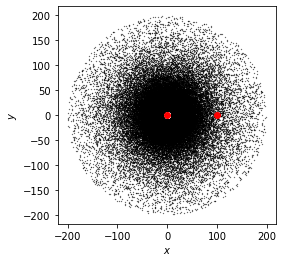

In [26]:
x, y, z = disc.arrays['position'][:, 0], disc.arrays['position'][:, 1], disc.arrays['position'][:, 2]

fig, ax = plt.subplots()
ax.plot(x[::10], y[::10], 'k.', ms=0.5)
for sink in setup.sinks:
    ax.plot(sink.position[0], sink.position[1], 'ro')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal')

Next we plot the particles in the rz-plane.

(-37.66126763271492, 36.95783658390337)

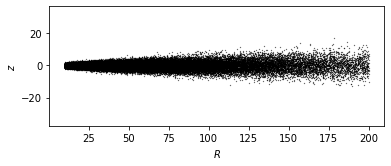

In [27]:
position_cylindrical, velocity_cylindrical = phantomsetup.geometry.coordinate_transform(
    position=disc.arrays['position'],
    velocity=disc.arrays['velocity'],
    geometry_from='cartesian',
    geometry_to='cylindrical'
)

R = position_cylindrical[:, 0]

fig, ax = plt.subplots()
ax.plot(R[::10], z[::10], 'k.', ms=0.5)
ax.set_xlabel('$R$')
ax.set_ylabel('$z$')
ax.set_aspect('equal')
ax.set_ylim(bottom=2 * z.min(), top=2 * z.max())

Finally, we plot $v_{\phi}$ as a function of radius.

Text(0, 0.5, '$v_{\\phi}$')

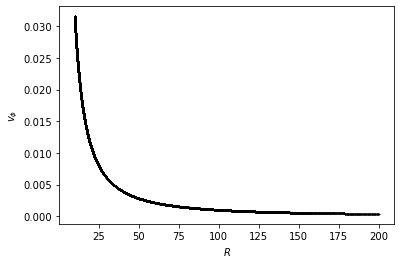

In [28]:
vphi = velocity_cylindrical[:, 1]

fig, ax = plt.subplots()
ax.plot(R[::10], vphi[::10], 'k.', ms=0.5)
ax.set_xlabel('$R$')
ax.set_ylabel('$v_{\phi}$')

## Write to file

Now that we are happy with the setup, write the "temporary" dump file with the initial conditions and the Phantom "in" file.

First we set a working directory for the simulation.

In [29]:
working_dir = '~/runs/disc'

In [30]:
setup.write_dump_file(directory=working_dir)
setup.write_in_file(directory=working_dir)

PhantomSetup('disc')

## Compile Phantom

You can start a Phantom calculation from these two files but you must compile Phantom with the correct Makefile variables. We can use the `phantom_compile_command` method to show how Phantom would be compiled.

In [31]:
print(setup.phantom_compile_command())

make \
  SETUP=empty \
  SYSTEM=gfortran \
  HDF5=yes \
  HDF5ROOT=/usr/local/opt/hdf5 \
  DISC_VISCOSITY=yes \
  DRIVING=no \
  DUST=no \
  DUSTGROWTH=no \
  GRAVITY=no \
  H2CHEM=no \
  IND_TIMESTEPS=yes \
  INJECT_PARTICLES=no \
  ISOTHERMAL=yes \
  KERNEL=cubic \
  MAXDUSTSMALL=11 \
  MAXDUSTLARGE=11 \
  MCFOST=no \
  MHD=no \
  NONIDEALMHD=no \
  PERIODIC=no \
  PHOTO=no


To compile Phantom we can use the `compile_phantom` method to compile Phantom. For example, the following will compile Phantom located in `phantom_dir` and copy the binary to `working_dir`.

```
result = setup.compile_phantom(
    phantom_dir='~/repos/phantom',
    working_dir=working_dir
)
```